# Cheat Sheet

## 0- Libraries 

In [ ]:
!conda install -c conda-forge folium=0.5.0 --yes

In [1]:
# !conda install -c conda-forge keplergl

In [ ]:
!conda install -c conda-forge  geopy

In [4]:
#Data import
from bs4 import BeautifulSoup
from scipy.sparse import csr_matrix  
from urllib.request import urlopen
import base64
import csv
import gzip
import io
import json
import numpy as np
import os
import pandas as pd
import requests
import scipy.sparse  
import string
import urllib
import urllib.request

#Data pre-processing
from collections import defaultdict
from datetime import datetime, date, time
from scipy.special import boxcox1p
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler
import datetime
import pandas_profiling as pp

#Data Viz
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import folium
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.datasets import make_moons
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

In [6]:
%matplotlib inline

In [5]:
os.getcwd()

'C:\\Users\\sbenoist\\Downloads'

# 1- Extract

In [6]:
# From csv
df = pd.read_csv('velib-disponibilite-en-temps-reel.csv',delimiter = ';')

In [7]:
# From a table from web
req = requests.get('http://www.parisavelo.net/liste-stations-velib/a-1.htm')
soup = BeautifulSoup(req.text, "html5lib") # lxml très rapide html5lib est très lent,  extrêmement indulgent
#Get title
soup.title
soup.title.name 
soup.title.string
#Get Tables
table = soup.find_all('table')[1].find_all('tbody')
board_members = []
#loop through table, grab each of the 4 columns shown (try one of the links yourself to see the layout)
for i in range(0,21):
    req = requests.get('http://www.parisavelo.net/liste-stations-velib/a-'+str(i)+'.htm')
    soup = BeautifulSoup(req.text, "html5lib")
    table = soup.find_all('table')[1].find_all('tbody')
    for ror in table:
        for row in ror.find_all('tr'):
            cols = row.find_all('td')
            board_members.append([cols[0].text.strip(),cols[1].text.strip(),cols[2].text.strip(),cols[3].text.strip()])
arr_df = pd.DataFrame(board_members, columns = ['code','name','arrondissement','date_service'])
arr_df['code']= arr_df['code'].astype(int)
arr_df['arrondissement']= arr_df['arrondissement'].astype(int)

In [447]:
#From jsom
df = pd.read_json('people_wiki_map_index_to_word.json',  typ='dataframe')

pandas.core.series.Series

In [448]:
# Import a parse matrix
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    return csr_matrix( (data, indices, indptr), shape)
word_count = load_sparse_csr('people_wiki_word_count.npz')

<59071x547979 sparse matrix of type '<class 'numpy.int64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

# 2-Cleaning

In [5]:
# Create dataframe df and ddf
df = pd.read_csv('library-monthly-stats.csv')
ddf = pd.read_csv('velib-disponibilite-en-temps-reel.csv',delimiter = ';')

In [6]:
#Data description
# profile = df.profile_report(title='Pandas Profiling Report')
# profile.to_file(output_file='output.html')
ddf.describe()
ddf.dtypes

Nombre de bornes disponibles       int64
Nombre vélo en PARK+               int64
Nombres de bornes en station       int64
PARK + activation                 object
densityLevel                       int64
Achat possible en station (CB)    object
Description station               object
maxBikeOverflow                    int64
Etat du Totem                     object
nbFreeDock                         int64
Nombre de vélo mécanique           int64
PARK +                            object
nbDock                             int64
Nombre vélo électrique             int64
Nombre vélo en PARK+.1             int64
Code de la station                 int64
Nom de la station                 object
Etat des stations                 object
Type de stations                  object
geo                               object
duedate                           object
dtype: object

In [10]:
#Missing values
a= df.isnull().sum() #Nb of null by columns
b = df[df.isnull().any(axis=1)] #See rows with Null

In [11]:
#Fill Missing  values
#Extrapolate
df0 = df.interpolate(method ='linear', limit_direction ='forward')
# Remove rows with NA
df1 = df.dropna() 
# Remove columns with NA
df2 = df.dropna(axis = 1) 
#Fill with next observation (other methods: {‘backfill’, ‘bfill’, ‘pad’, ‘ffill’, None})
df3 = df.fillna(method ='bfill') 
# Replace null values by '-99'
df4 = df.replace(to_replace = np.nan, value = -99)
 #interpolate by placing mean values using sci-kit learn
imr = SimpleImputer(missing_values=np.nan, strategy='median')
imr = imr.fit(df[['New Cardholders']])
imputed_data = imr.transform(df[['New Cardholders']])
df['New Cardholders'] = imputed_data

In [12]:
#New columns
ddf['lon'] = ddf['geo'].apply(lambda i: i.split(',')[1] ) #New value from an existing column
ddf['lat'] = ddf['geo'].apply(lambda i: i.split(',')[0] ) #New value from an existing column
ddf['Achat possible en station (CB)'] = ddf['Achat possible en station (CB)'].astype('str') #Change Type
ddf['month'] = ddf['duedate'].apply(lambda i: datetime.strptime(i,'%Y-%m-%d').month)
ddf['maxx'] = ddf[['nbFreeDock','nbDock']].max(axis = 1) #Better than apply to calculate with several columns
#(ddf['maxx'] == ddf['nbDock']).any() #Compare 2 columns

AttributeError: module 'datetime' has no attribute 'strptime'

In [ ]:
#Type of columns
df.dtypes #Type by columns
df.select_dtypes(include= 'object') #Dataframe with only 'object' columns
col = df.select_dtypes(include= 'int64').columns  #List of columns with 'int'
a = df.dtypes.value_counts() #Nb of columns by type

In [ ]:
#Select rows and columns
ddf2 = ddf[ddf['Etat des stations'].isin(['Operative','Work in progress'])]
ddf.drop(columns = 'nbFreeDock', inplace = True)

In [13]:
#Copy
df1 = df2.copy()# df1 = df2 would just assign and not copy

In [17]:
#Bins  with cut
df['Total Computer Usage (Wireless + PC Sessions)'] = df['Total Computer Usage (Wireless + PC Sessions)'].replace(to_replace = np.nan, value = 0).astype(int)
df['bin'] = pd.cut(x = df['Total Computer Usage (Wireless + PC Sessions)'],
       bins = [3e+05,4.0058e+05,5.3e+05], #percentiles values
       include_lowest = True,
       labels = [1,2])
#Bin by percentiles
percent = [np.percentile(df['Total Computer Usage (Wireless + PC Sessions)'],i) for i in [25,50,75]]
df['group'] = 1
for i in range(3):
    df['group'] = df['group'] + (df['Total Computer Usage (Wireless + PC Sessions)'] < percent[i])

In [18]:
#Label Encoding
a = ddf['Etat des stations'].value_counts() #See nb by categories
A  = ddf['Etat des stations'].astype('category').cat.codes  #Transform categories to int
#Sklearn label Encoding
target_feature = 'Etat des stations'
#use encoder and transform
encoder = LabelEncoder()
encoded_values = encoder.fit_transform(ddf[target_feature].values)
ddf[target_feature] = pd.Series(encoded_values, index=ddf.index)
print(np.unique(ddf[target_feature]))
#to inverse, use inverse method
decoded = encoder.inverse_transform(ddf[target_feature].values)
ddf[target_feature] = pd.Series(decoded, index=ddf.index)
print(np.unique(ddf[target_feature]))

[0 1 2 3]
['Close' 'Neutralised' 'Operative' 'Work in progress']


In [19]:
#One Hot Encoding
new_ddf = pd.get_dummies(ddf, columns=["Etat des stations"]).columns #Columns added for each value

In [20]:
#Relative Frequency
a = ddf['Etat des stations']
a = pd.crosstab(a, 1,normalize='all').round(2)

In [22]:
#Skewness
a = df.skew().sort_values()>0.8
col2 = list(a[a == True].index)
for c in col2:
    df[c] = boxcox1p(df[c], 0.001)

In [35]:
#loop
# For dataframe: df.interrows()
class_list = list()
for index, data_row in ddf.iterrows():
    a = data_row['Etat des stations']
    class_list.append(a)    
#range(start, stop, step): for i in range(3, 16, 3)
#range(stop): for i in range(3)
#k-dimensional arrays: for val in np.nditer(z)
# For dictionaries: for key, value in dico.items() 
#Break and Continue
languages = [['Spanish', 'English',  'French', 'German'], ['Python', 'Java', 'Javascript', 'C++']]
for lang in languages:
    for x in lang:
#         print('---')
        if x == 'German':
            continue
#         print(x)
        if x == 'Python':
            break

# Export to csv clean dataset

In [47]:
df.to_csv('test.csv',sep = ';')

# Machine Learning

## Test- Train Split

In [384]:
df = df.dropna()
X = df.select_dtypes(exclude= 'object')
X.drop(columns = 'Total_Library_Visitors', inplace = True )
y = df[['Total_Library_Visitors']]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.9, random_state=1)
#X_validation, X_test, y_validation, y_test  = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

C:\Users\sbenoist\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [ ]:
#Normalization
std = StandardScaler()
std = std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

## Supervised Model

In [385]:
lr = LinearRegression()
reg = lr.fit(X_train,y_train)
y_pred = lr.predict(X)
print('Score train set: {0:.2f}'.format(lr.score(X_train,y_train)))
print('Score test set: {0:.2f}'.format(lr.score(X_test,y_test)))

Score train set: 1.00
Score test set: 0.18


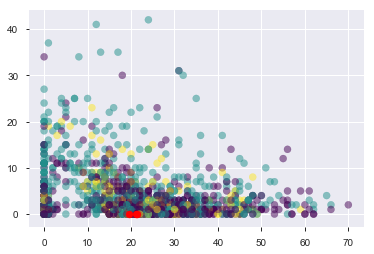

In [432]:
ddf_clus = ddf.select_dtypes(include = 'int64')
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3).fit(ddf_clus)
centroids = kmeans.cluster_centers_
plt.scatter(ddf_clus['Nombre de bornes disponibles'], ddf_clus['Nombre de vélo mécanique'], c= kmeans.labels_.astype(float), s=50, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)

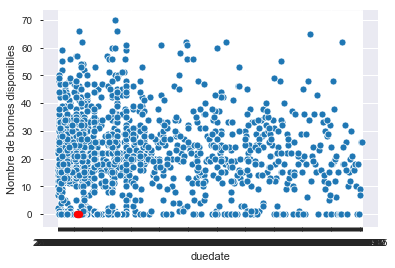

In [433]:
sns.scatterplot(x='duedate', y='Nombre de bornes disponibles', data=ddf)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)

In [434]:
ddf['cluster'] = pd.DataFrame(kmeans.labels_)

In [38]:
ddf.columns

Index(['Nombre de bornes disponibles', 'Nombre vélo en PARK+',
       'Nombres de bornes en station', 'PARK + activation', 'densityLevel',
       'Achat possible en station (CB)', 'Description station',
       'maxBikeOverflow', 'Etat du Totem', 'nbFreeDock',
       'Nombre de vélo mécanique', 'PARK +', 'nbDock',
       'Nombre vélo électrique', 'Nombre vélo en PARK+.1',
       'Code de la station', 'Nom de la station', 'Etat des stations',
       'Type de stations', 'geo', 'duedate', 'lon', 'lat'],
      dtype='object')

# Visualization

In [7]:
df.boxplot(column = '# of Homeless Individuals Served at The Source', by = 'group' , showmeans=True)

KeyError: 'group'

<BarContainer object of 63 artists>

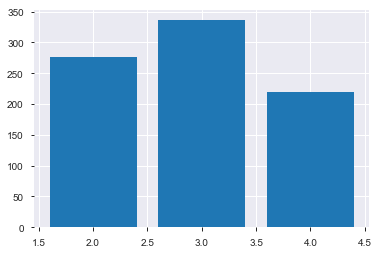

In [68]:
x = df['group']
y = df['#_of_Homeless_Individuals_Served_at_The_Source']
plt.bar(x  ,y)

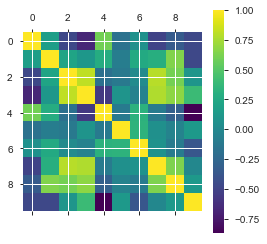

In [427]:
plt.matshow(df.corr(), cmap='viridis')
plt.colorbar()

C:\Users\sbenoist\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


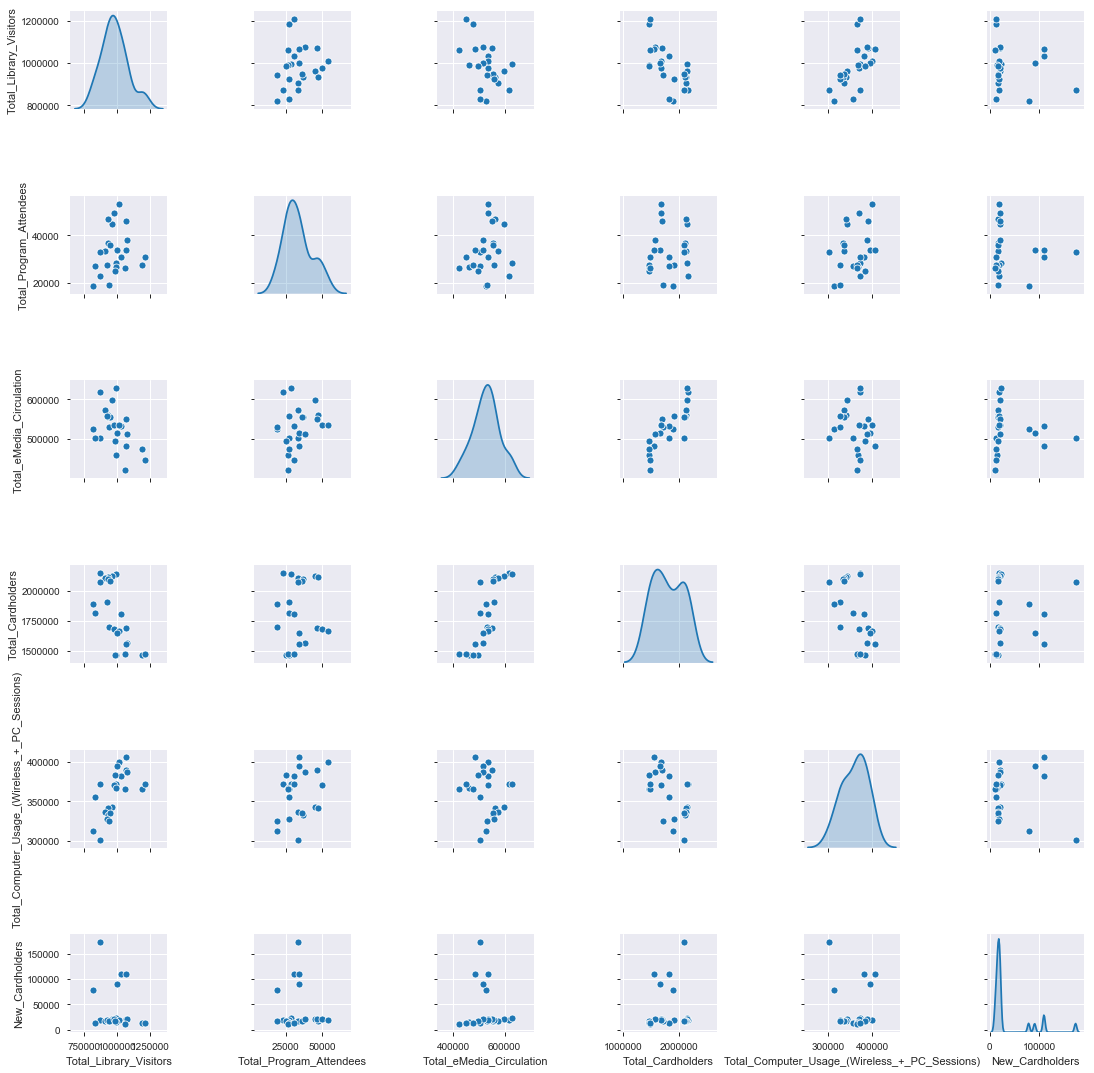

In [440]:
sns.pairplot(df[['Total_Library_Visitors', 'Total_Program_Attendees',
       'Total_eMedia_Circulation', 'Total_Cardholders',
       'Total_Computer_Usage_(Wireless_+_PC_Sessions)', 'New_Cardholders']], diag_kind="kde")

In [7]:
ddf.dtypes

Nombre de bornes disponibles       int64
Nombre vélo en PARK+               int64
Nombres de bornes en station       int64
PARK + activation                 object
densityLevel                       int64
Achat possible en station (CB)    object
Description station               object
maxBikeOverflow                    int64
Etat du Totem                     object
nbFreeDock                         int64
Nombre de vélo mécanique           int64
PARK +                            object
nbDock                             int64
Nombre vélo électrique             int64
Nombre vélo en PARK+.1             int64
Code de la station                 int64
Nom de la station                 object
Etat des stations                 object
Type de stations                  object
geo                               object
duedate                           object
dtype: object

In [ ]:
#Loop in a figure
ax, fig = plt.subplots()
colors = dict(zip(set(ddf['Etat des stations'].values),['r','b','p','b']))
x = ddf['Description station']
y = ddf['Nombre de bornes disponibles']
for i,row in ddf.iterrows():
    plt.scatter(x[i],y[i], color = 'r')
    if i> 1000:
        break
    
    

In [42]:
ddf.select_dtypes(exclude= 'object') .columns

ddff = ddf[['Nombre de bornes disponibles', 'Nombre vélo en PARK+',
       'Nombres de bornes en station','nbDock']]


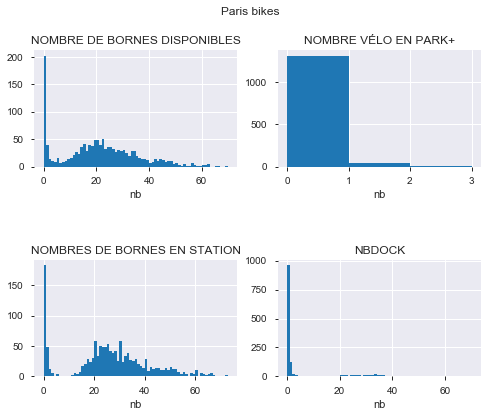

In [52]:
#  color[row['Etat des stations']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
fig.subplots_adjust(hspace=0.8)
fig.suptitle('Paris bikes')
for ax, feature, name in zip(axes.flatten(), ddff.T.values, ddff.columns.values):
    ax.hist(feature,max(feature))
    ax.set(title=name.upper(), xlabel='nb')


# Map

In [435]:
#Draw Map
coords = (48.8566039746,2.33474291861)
map = folium.Map(location=coords, tiles='OpenStreetMap', zoom_start=12)

#Add group based on a geo-json file
geop = r'arrondissements.geojson'
open('arrondissements.geojson').read()
map.add_child(folium.GeoJson('arrondissements.geojson'))

#Add Market
for ix, row in ddf.iterrows():
    if row['cluster'] == 1:
        folium.CircleMarker(location = [float(row['lat']),float(row['lon'])], radius=2, color='green', fill_color='#0000FF').add_to(map)
    elif row['cluster'] == 0:
        folium.CircleMarker(location = [float(row['lat']),float(row['lon'])], radius=2, color='blue', fill_color='#0000FF').add_to(map)
    else:
        folium.CircleMarker(location = [float(row['lat']),float(row['lon'])], radius=2, color='red', fill_color='#0000FF').add_to(map)
map

In [358]:
ddfM = ddf.merge(arr_df,left_on='Code de la station', right_on='code')
station_nb0 = ddfM.groupby('arrondissement').agg({'Code de la station' : 'count'})
station_nb0['c_ar'] = station_nb0.index.astype('int')
station_nb0['count'] = station_nb0['Code de la station'] 
station_nb = station_nb0[['c_ar','count']]


In [367]:
map.choropleth(
    geo_data =geop,
    name='choropleth',
    data = station_nb,
    columns = ['c_ar','count'],
    key_on='features.properties.c_ar',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2
)


In [366]:
json.load(open(geop))['features'][7]['properties']['c_ar']


19

In [324]:
#Choropleth Map

#Data: Agreggate crime by Neighborhood
crime = pd.read_csv('https://cocl.us/sanfran_crime_dataset')
crime_nb = crime.groupby('PdDistrict').agg({'IncidntNum' : 'count'})
crime_nb['neighborhood'] = crime_nb.index
crime_nb['count'] = crime_nb['IncidntNum']
crime_nb.drop(columns = 'IncidntNum', inplace = True)

#Geo json Neighborhood mapping
geo = r'https://cocl.us/sanfran_geojson'

#Draw map
local_map = folium.Map(location=[37.775420706711,-122.403404791479], zoom_start=12)

#Add Neighborhood
local_map.choropleth(
    geo_data=geo,
    data=crime_nb,
    columns=['neighborhood','count'],
    key_on='feature.properties.DISTRICT',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Crime in San Francisco'
)

local_map

ddf

In [206]:
ddf[['arrondissement_y','Code de la station']]

,arrondissement_y,arrondissement_y,arrondissement_y,Code de la station
0,1,1,1,1001
1,1,1,1,1022
2,1,1,1,1016
3,1,1,1,1002
4,1,1,1,1003
5,1,1,1,1006
6,1,1,1,1026
7,1,1,1,1020
8,1,1,1,1014
9,1,1,1,1025
